In [3]:
import numpy as np
import pandas as pd

class LogisticRegressionSGD:
    def __init__(self, lambda_=0):
        self.w = 0.0
        self.b = 0.0
        self.lambda_ = lambda_
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, y, y_hat):
        m = len(y)
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        return (-np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) + (self.lambda_ / (2 * m)) * np.sum(self.w ** 2))

    def compute_gradient(self, X, y):
        m = len(y)
        y_hat = self.sigmoid(np.dot(X, self.w) + self.b)
        error = y_hat - y
        gradient_w = (np.dot(X.T, error) + self.lambda_ * self.w) / m
        gradient_b = np.sum(error) / m
        return gradient_w, gradient_b

    def train(self, X, y, alpha=0.01, num_rounds=1000):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()

        n = X.shape[1]
        self.w = np.zeros(n)

        for _ in range(num_rounds):
            gradient_w, gradient_b = self.compute_gradient(X, y)
            self.w -= alpha * gradient_w
            self.b -= alpha * gradient_b
            y_hat = self.predict_proba(X)
            self.loss_history.append(self.compute_loss(y, y_hat))

        return self
    
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X):
        return np.array([int(p >= 0.5) for p in self.predict_proba(X)])

In [63]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/features.csv")
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[["Gender", "France", "Germany", "Spain"]], random_state=42)

X_train = df_train.drop(["CustomerId", "Exited"], axis=1)
y_train = df_train["Exited"]
X_test = df_test.drop(["CustomerId", "Exited"], axis=1)
y_test = df_test["Exited"]

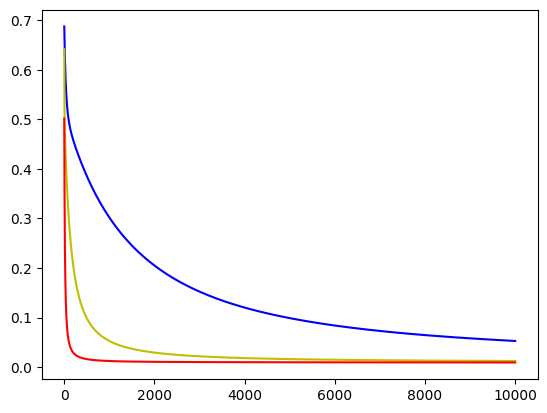

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

alphas = [0.01, 0.1, 1]
loss_log = {}
for alpha in alphas:
    lrsgd = LogisticRegressionSGD()
    lrsgd_model = lrsgd.train(X_train, y_train, alpha, 10000)
    loss_log[alpha] = lrsgd_model.loss_history

plt.plot(loss_log[0.01], "b")
plt.plot(loss_log[0.1], "y")
plt.plot(loss_log[1], "r")

In [10]:
from sklearn.metrics import f1_score

lrsgd = LogisticRegressionSGD()
lrsgd_model = lrsgd.train(X_train, y_train, 0.1, 10000)
y_hat = lrsgd_model.predict(X_test)
f1_score(y_test, y_hat)

0.9987261146496815

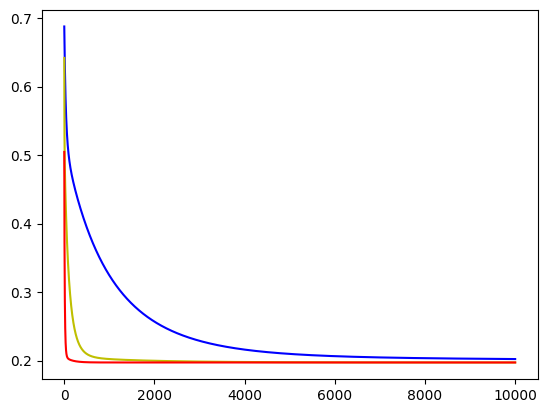

In [11]:
alphas = [0.01, 0.1, 1]
loss_log = {}
for alpha in alphas:
    lrsgd = LogisticRegressionSGD(lambda_=100)
    lrsgd_model = lrsgd.train(X_train, y_train, alpha, 10000)
    loss_log[alpha] = lrsgd_model.loss_history

plt.plot(loss_log[0.01], "b")
plt.plot(loss_log[0.1], "y")
plt.plot(loss_log[1], "r")

In [114]:
lrsgd_w_reg = LogisticRegressionSGD(lambda_=100)
lrsgd_model_w_reg = lrsgd_w_reg.train(X_train, y_train, 0.1, 10000)
y_hat = lrsgd_model_w_reg.predict(X_test)
f1_score(y_test, y_hat)

0.9987261146496815

In [132]:
lrsgd_model.w

array([-2.02301734e-01, -1.61005720e-02, -2.44471038e-01,  3.75376890e+00,
       -8.01281617e-03,  1.09570546e-01,  1.57883672e-02,  1.21101464e-01,
       -1.10482666e-01,  1.57851420e-01, -4.73687539e-02, -1.69014984e-02,
        3.39702396e-01, -1.75085950e-02,  6.89606713e-02, -3.90710066e-03,
        1.59872063e-02, -2.13365156e-02,  1.15218682e-02, -5.82546281e-02,
        3.86671303e-04, -2.61656981e-01,  1.69193741e-03,  1.09934730e-01,
        1.27563047e-01, -1.20488071e-02, -1.13534067e-01])

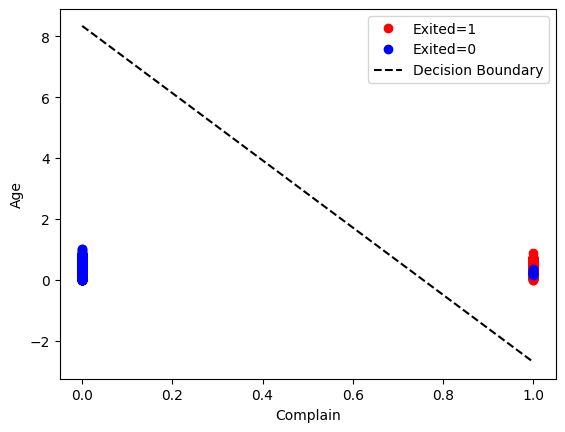

In [137]:
df_train_p = df_train[df_train["Exited"] == 1]
df_train_n = df_train[df_train["Exited"] == 0]
X_train_p = df_train_p.drop(["CustomerId", "Exited"], axis=1).values
y_train_p = df_train_p["Exited"].values
X_train_n = df_train_n.drop(["CustomerId", "Exited"], axis=1).values
y_train_n = df_train_n["Exited"].values

f1, f2 = 3, 12
plt.plot(X_train_p[:, f1], X_train_p[:, f2], "ro", label="Exited=1")
plt.plot(X_train_n[:, f1], X_train_n[:, f2], "bo", label="Exited=0")

w = lrsgd_model.w
b = lrsgd_model.b
means = np.mean(X_train.values, axis=0)
const = np.sum(w * means) - w[f1]*means[f1] - w[f2]*means[f2] + b
x_ = np.linspace(np.min(X_train.values[:, f1]), np.max(X_train.values[:, f1]), 100)
y_ = -(w[f1] * x_ + const) / w[f2]

plt.plot(x_, y_, 'k--', label="Decision Boundary")
plt.xlabel(X_train.columns[f1])
plt.ylabel(X_train.columns[f2])
plt.legend()
plt.show()

In [144]:
y_hat_h = (X_test["Complain"] == 1).astype(int).values
f1_score(y_test, y_hat_h)

0.9987261146496815

In [136]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)
f1_score(y_test, lr_model.predict(X_test))

0.9987261146496815

## Model Training Using Neural Networks

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [64]:
X_train = torch.from_numpy(X_train.values).type(torch.float).to(device)
X_test = torch.from_numpy(X_test.values).type(torch.float).to(device)
y_train = torch.from_numpy(y_train.values).type(torch.float).to(device)
y_test = torch.from_numpy(y_test.values).type(torch.float).to(device)

In [65]:
class ChurnPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=27, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=4)
        self.layer_4 = nn.Linear(in_features=4, out_features=2)
        self.layer_5 = nn.Linear(in_features=2, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))

In [ ]:
torch.manual_seed(42)
epochs = 1000

alphas = [0.01, 0.1, 1]
loss_log = {}

for alpha in alphas:
    cp = ChurnPredictor().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(cp.parameters(), lr=alpha)
    loss_history = []

    for epoch in range(epochs):
        y_logits = cp(X_train).squeeze()
        loss = loss_fn(y_logits, y_train)
        loss_history.append(loss.cpu().detach().numpy().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_log[alpha] = loss_history

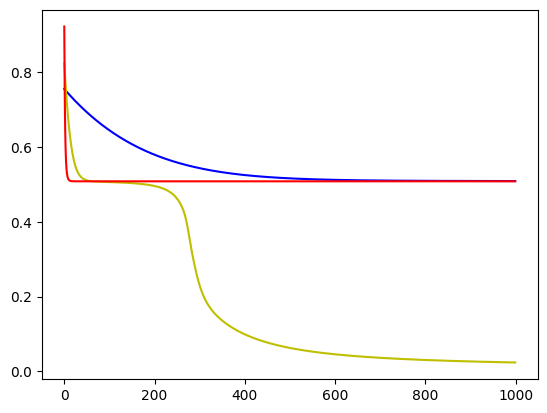

In [67]:
plt.plot(loss_log[0.01], "b")
plt.plot(loss_log[0.1], "y")
plt.plot(loss_log[1], "r")

In [68]:
cp = ChurnPredictor().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(cp.parameters(), lr=0.1)
loss_history = []

for epoch in range(epochs):
    y_logits = cp(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

cp.eval()
with torch.inference_mode():
    y_logits = cp(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    f1 = f1_score(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

print(f1)

0.9987261146496815
